In [1]:
import numpy as np
from skimage.io import imread
from tqdm import tqdm
import glob, os, dxchange
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp 


olefile module not found


In [1]:
# select IPTSa

In [ ]:
# Select top folder of data to reconstruct
## program will load and automatically make a list of good runs and bad runs  

In [4]:
# combine all the images within each run

In [2]:
# parameters used for data cleaning
"""
if_clean: switch of cleaning operation (bool)
if_save_clean: switch of saving cleaned tiff files (bool)
low_gate: the lower index of the image hist bin edges (int 0-9)
high_gate: the higher index of the image hist bin edges (int 0-9)
correct_radius: the neighbors (2r+1 * 2r+1 matrix) radius used for replacing bad pixels (int) 
"""
clean_paras = {'if_clean': True, 'if_save_clean': False, 'low_gate': 1, 'high_gate': 9, 'correct_radius': 1}

In [2]:
# pre-processing
"""
DataCleaner Class: find the abnormal pixels (extremely low/high) and replaced by median value of the neighor matrix
===========
to initiate cleaner: 
data_cleaner = DataCleaner(clean_paras, clean_path)
[clean_paras]: parameters used for cleaning (dictionary)
[clean_path]: the directory where save the cleaned data (if save) and logs (strings)
===========
to clean a 2D image:
cleaned_data = data_cleaner(orginal_im, save_file_name)
[original_im]: the image need to be cleaned (M*M array)
[save_file_name]: the cleaned tiff and its log will be saved in this name (strings)

"""

class DataCleaner(object): 
    def __init__(self, paras, clean_path):
        # for clean data
        self.low_gate = paras['low_gate']
        self.high_gate = paras['high_gate']
        self.r = paras['correct_radius']
        self.CLEAN = paras['if_clean']
        self.SAVE_CLEAN = paras['if_save_clean']
        self.clean_path = clean_path
        
    def run(self, im, fname):
        self.im = im
        self.row, self.col = self.im.shape
        self.corr_im = np.nan_to_num(self.im.copy(), nan=0, posinf=0, neginf=0)
        self.log = {}
        self.fname = fname

        if self.CLEAN:
            self.replace_pix()
            self.save_opt()

    def replace_pix(self):
        hist, bin_edges = np.histogram(self.corr_im.flatten(), density=False)
        thres_low = bin_edges[self.low_gate]
        thres_high = bin_edges[self.high_gate]
        x_coords, y_coords = np.nonzero(np.logical_or(self.corr_im <= thres_low, self.corr_im > thres_high))
        r = self.r

        org_val, cor_val = [], []
        for x, y in zip(x_coords, y_coords):
            X_, _X = max(0, x-r), min(self.corr_im.shape[0], x+r)
            Y_, _Y = max(0, y-r), min(self.corr_im.shape[1], y+r)
            org_val.append(self.corr_im[x, y])
            pat = self.im[X_ : _X+1, Y_: _Y+1]
            if np.nonzero(pat > thres_low)[0].size >=4:
                _elements = list(pat.flatten())
                _elements.pop(r*(1+2*r)+r)
                _corrected = np.median(_elements)#sum(_elements)/(pat.size-1)
                self.corr_im[x, y] = _corrected
                cor_val.append(_corrected)
            else:
                print('ERROR, too many zeros around pixel({},{})'.format(x, y))
                cor_val.append('-')
        
        self.log = {'fname': self.fname, 'X': x_coords, 'Y': y_coords, 
                    'original': org_val, 'corrected': cor_val}
        
    def save_opt(self):
        if self.SAVE_CLEAN:
            _fname = os.path.join(self.clean_path, f'ZeroRemove_{self.fname}')
            dxchange.writer.write_tiff(self.corr_im, fname=_fname, overwrite=True)

        log_fld = os.path.join(self.clean_path, 'logs')
        df = pd.DataFrame.from_dict(self.log, orient='columns')
        log_name = os.path.join(log_fld, f'clean_log_{self.fname}.csv')
        df.to_csv(log_name)
        
        print(f'save log into {log_name}')


In [4]:
def worker(fl):
    return (imread(fl).astype(np.float32)).swapaxes(0,1)

def hype_loader_sum(fls_lst):
    with mp.Pool(processes=10) as pool:
        data = pool.map(worker, fls_lst)

    return np.array(data).sum(axis=0)[10:-10, 10:-10]

In [5]:
# load a data
fld_path = ('/SNS/VENUS/IPTS-33699/shared/processed_data/'
            'September20_2024_PurpleCar_GoldenRatio_CT_5_0_C_Cd_inBeam_Resonance')
flds = glob.glob(os.path.join(fld_path, 'Run*')) # find all projections
flds.sort()

projs = []
for fld in tqdm(flds):
    fls_lst = glob.glob(os.path.join(fld, '*.tif*'))
    fls_lst.sort()
    projs.append(hype_loader_sum(fls_lst))

100%|██████████| 82/82 [18:38<00:00, 13.64s/it]


In [62]:
#data = []






In [64]:
hype_data.shape

(2702, 512, 512)

In [65]:
# sum all bands
sum_im = hype_data.sum(axis=0)[10:-10, 10:-10]

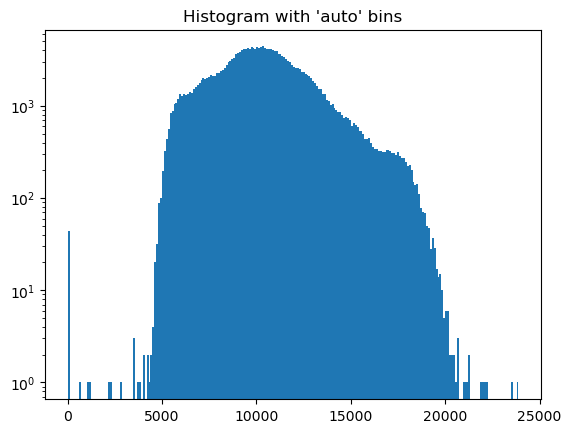

In [5]:
# display histogram
plt.hist(sum_im.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.yscale('log')

In [6]:
# check the details of histogram
hist, bin_edges = np.histogram(sum_im.flatten(), density=False)
bin_edges[9]

21493.766

In [16]:
# initialize cleaner
data_cleaner = DataCleaner(clean_paras, clean_path='/home/gxt/Projects')

In [23]:
# clean the data
data_cleaner.run(sum_im, 'Run_3141')
clean_im = data_cleaner.corr_im
clean_log = data_cleaner.log

save log into /home/gxt/Projects/logs/clean_log_Run_3141.csv


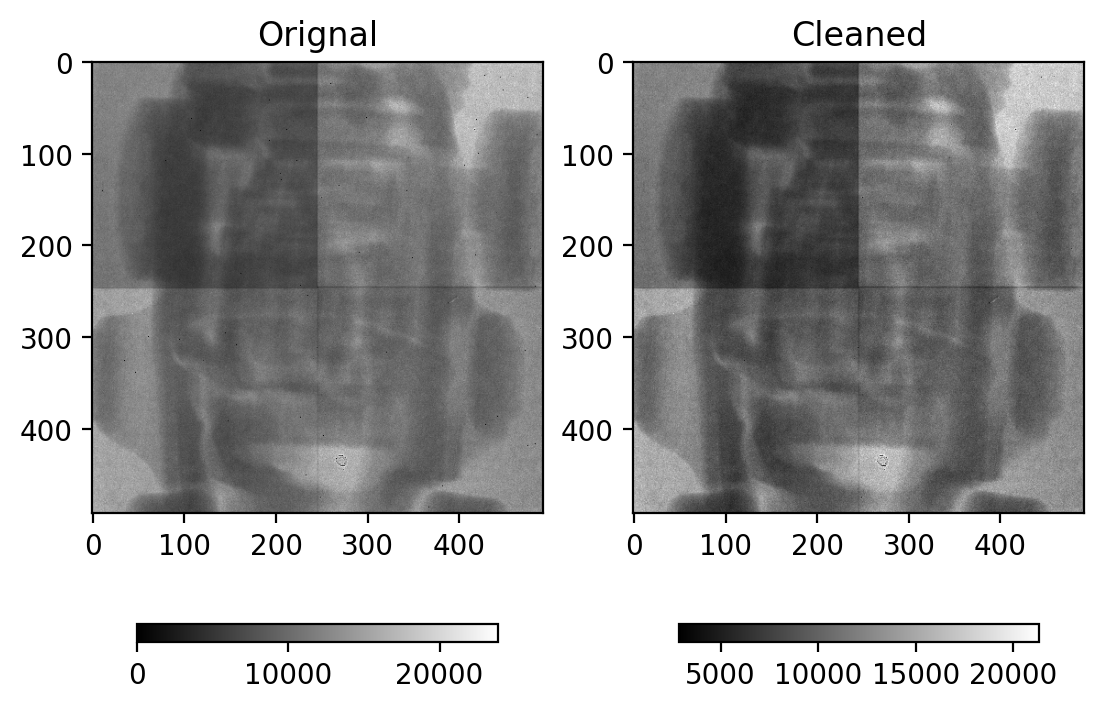

In [40]:
fig, axs = plt.subplots(1,2, dpi = 200)
pcm0 = axs[0].imshow(sum_im, cmap='gray')
axs[0].set_title('Orignal')
fig.colorbar(pcm0, ax=axs[0], shrink=0.8, orientation = 'horizontal')

pcm1 = axs[1].imshow(clean_im, cmap='gray')
axs[1].set_title('Cleaned')
fig.colorbar(pcm1, ax=axs[1], shrink=0.8, orientation = 'horizontal')


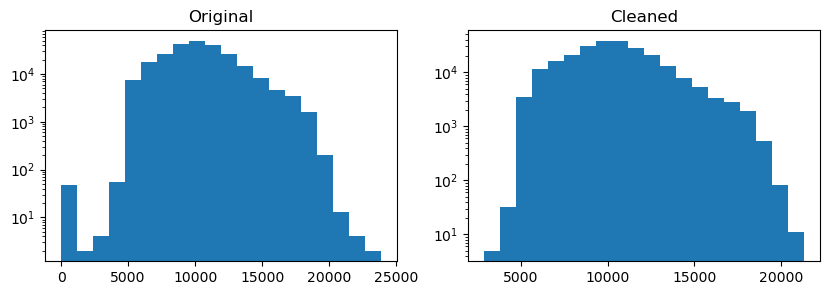

In [48]:
fig, axs = plt.subplots(1,2, figsize = (10, 3), dpi = 100)

axs[0].hist(sum_im.flatten(), bins=20)  # arguments are passed to np.histogram
axs[0].set_title("Original")
axs[0].set_yscale('log')

axs[1].hist(clean_im.flatten(), bins= 20)  # arguments are passed to np.histogram
axs[1].set_title("Cleaned")
axs[1].set_yscale('log')

In [7]:
# normalization

In [8]:
# chips correction

In [9]:
# calculate center of rotation

In [10]:
# calculate tilt correction and apply it

In [ ]:
# launch svmbir